# Usage

## Getting Started

Most of the functionality of PyMatching is available through the `pymatching.matching.Matching` class, which can be imported in Python with:

In [1]:
from pymatching import Matching

The `Matching` class is used to represent the $X$-type or $Z$-type matching graph of a CSS quantum code for which syndrome defects come in pairs (or in isolation at a boundary). Each edge in the matching graph corresponds to a single error, and each node corresponds to a stabiliser measurement (or a boundary). The simplest way to construct a `Matching` object is from the X or Z check matrix of the code, which can be given as a numpy or a scipy array. For example, we can construct the $Z$-type matching graph for a five-qubit quantum bit-flip repetition code (which has $Z$ stabilisers $ZZIII$, $IZZII$, $IIZZI$ and $IIIZZ$) from the $Z$ check matrix using:

In [2]:
import numpy as np

"""
Each column of Hz corresponds to a qubit, and each 
row corresponds to a Z stabiliser.

Hz[i,j]==1 if Z stabiliser i acts non-trivially
on qubit j, and is 0 otherwise.
"""
Hz = np.array([
    [1,1,0,0,0],
    [0,1,1,0,0],
    [0,0,1,1,0],
    [0,0,0,1,1]
])

m = Matching(Hz)
m

<pymatching.Matching object with 5 qubits, 4 stabilisers, 1 boundary node, and 5 edges>

Note that, since two qubits (0 and 4) are incident to only a single stabiliser, a boundary node has automatically been created in the matching graph, and is connected to the stabilisers acting non-trivially on qubits 0 and 4. The weights of all edges in the matching graph default to 1.0, unless they are specified using the `spacelike_weights` parameter.

We can visualise the matching graph using the `Matching.draw()` method:

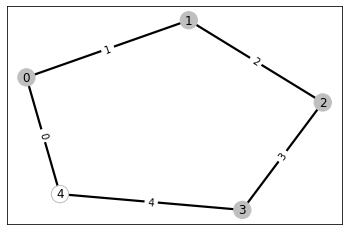

In [3]:
%matplotlib inline
m.draw()

Note that the stabiliser nodes are shown as filled circles, and the boundary node (labelled 4) is shown as a hollow circle. Each edge is labelled with its `qubit_id`.

If $X$ errors occur on the third and fourth qubits we have a binary noise vector:

In [4]:
noise = np.array([0,0,1,1,0])

and the resulting syndrome vector is:

In [5]:
z = Hz@noise % 2
print(z)

[0 1 0 1]


This syndrome vector `z` can then be decoded simply using:

In [6]:
c = m.decode(z)
print(f"c: {c}, of type {type(c)}")

c: [0 0 1 1 0], of type <class 'numpy.ndarray'>


where `c` is the $X$ correction operator (i.e. $IIXXI$).

Note that for larger check matrices you may instead prefer to use a scipy sparse matrix to represent the check matrix:

In [7]:
import scipy

Hz = scipy.sparse.csr_matrix(Hz)
m = Matching(Hz)
m

<pymatching.Matching object with 5 qubits, 4 stabilisers, 1 boundary node, and 5 edges>

## Noisy Syndromes

### Spacetime matching graph

If stabiliser measurements are instead noisy, then each stabiliser measurement must be repeated, with each defect in the matching graph corresponding to a change in the syndrome (see IV B of [this paper](https://arxiv.org/abs/quant-ph/0110143)). We will repeat each stabiliser measurement 5 times, with each qubit suffering an $X$ error with probability `p`, and each stabiliser will be measured incorrectly with probability `q`. Spacelike edges will be weighted with $\log((1-p)/p)$ and timelike edges will be weighted with $\log((1-q)/q)$. The Matching object representing this spacetime matching graph can be constructed using:

In [8]:
repetitions=5
p = 0.05
q = 0.05
m2d = Matching(Hz, 
               spacelike_weights=np.log((1-p)/p),
               repetitions=repetitions,
               timelike_weights=np.log((1-q)/q)
              )

### Simulate noisy syndromes

Now if each qubit suffers an $X$ error with probability `p` in each round of stabiliser measurements, the errors on the data qubits can be given as a 2D numpy array:

In [9]:
num_stabilisers, num_qubits = Hz.shape
np.random.seed(1) # Keep RNG deterministic
noise_new = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)
noise_new # New errors in each time step

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [10]:
noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
noise_total = noise_cumulative[:,-1] # Total cumulative noise at the last round
noise_cumulative # Cumulative errors in each time step

array([[0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

The corresponding noiseless syndrome would be:

In [11]:
z_noiseless = Hz@noise_cumulative % 2
z_noiseless # Noiseless syndrome

array([[0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

We assume each syndrome measurement is incorrect with probability `q`, but that the last round of measurements is perfect to ensure an even number of defects (a simple approximation - the overlapping recovery method could be used in practice):

In [12]:
z_err = (np.random.rand(num_stabilisers, repetitions) < q).astype(np.uint8)
z_err[:,-1] = 0
z_err # Syndrome errors

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [13]:
z_noisy = (z_noiseless + z_err) % 2
z_noisy # Noisy syndromes

array([[0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0]])

In [14]:
z_noisy[:,1:] = (z_noisy[:,1:] - z_noisy[:,0:-1]) % 2
z_noisy # Convert to difference syndrome

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

### Decode

Decoding can now be done just by inputting this 2D syndrome vector to the `Matching.decode` method:

In [15]:
correction = m2d.decode(z_noisy)
correction

array([1, 0, 1, 0, 0], dtype=uint8)

And we see that this correction operator successfully corrects the cumulative total noise:

In [16]:
(noise_total + correction) % 2

array([0, 0, 0, 0, 0], dtype=uint8)

## Loading from NetworkX graphs

While it can be convenient to decode directly from the check matrices, especially when simulating under a standard independent or phenomenological noise model, it is sometimes necessary to construct the matching graph nodes, edges, weights and boundaries explicitly. This is useful for decoding under more complicated (e.g. circuit-level) noise models, for which matching graph edges can be between nodes separated in both space and time ("diagonal edges"). There can also be so called "hook errors", which are single faults (matching graph edges) corresponding to errors on two or more qubits. Furthermore, the stabilisers themselves can change as a function of time when using schedule-induced gauge fixing of a subsystem code (see [this paper](https://arxiv.org/abs/2010.09626)).

To provide the functionality to handle these use cases, PyMatching allows Matching objects to be constructed explicitly from [NetworkX](https://networkx.org/documentation/stable/index.html) graphs.

Each node in the matching graph with $n$ nodes, represented by the `pymatching.Matching` object, should be uniquely identified by an integer between $0$ and $n-1$ (inclusive). Edges are then added between these integer nodes, with optional attributes `weight`, `qubit_id` and `error_probability`. 

We will again use the quantum repetition code as an example. Let's create a quantum repetition code `Matching` object on five qubits from a NetworkX graph:

In [17]:
import networkx as nx

p = 0.2
g = nx.Graph()
g.add_edge(0, 1, qubit_id=0, weight=np.log((1-p)/p), error_probability=p)
g.add_edge(1, 2, qubit_id=1, weight=np.log((1-p)/p), error_probability=p)
g.add_edge(2, 3, qubit_id=2, weight=np.log((1-p)/p), error_probability=p)
g.add_edge(3, 4, qubit_id=3, weight=np.log((1-p)/p), error_probability=p)
g.add_edge(4, 5, qubit_id=4, weight=np.log((1-p)/p), error_probability=p)

Just for the purpose of demonstration, we'll assume that there is also an error process that gives a single hook error on qubits $2$ and $3$, corresponding to a single edge between node $2$ and node $4$. This error will occur with probability `p2`. This can be added using:

In [18]:
p2 = 0.12
g.add_edge(2, 4, qubit_id={2, 3}, weight=np.log((1-p2)/p2), error_probability=p2)

Since nodes 0 and 5 are incident to only a single edge, they must be specified as being boundary nodes, which can be done by setting their optional `is_boundary` attribute to `True`:

In [19]:
g.node[0]['is_boundary'] = True
g.node[5]['is_boundary'] = True

We now connect these boundary nodes with an edge of `weight` zero, and with a `qubit_id` either unspecified or set to `set()` or `-1` (since edges between boundaries do not correspond to qubit faults):

In [20]:
g.add_edge(0, 5, weight=0.0, qubit_id=-1, error_probability=0.0)

Finally, we can now use this NetworkX graph to construct the `Matching` object:

In [21]:
m = Matching(g)
m

<pymatching.Matching object with 5 qubits, 4 stabilisers, 2 boundary nodes, and 7 edges>

We can also use the `Matching.draw()` method to visualise our matching graph as before:

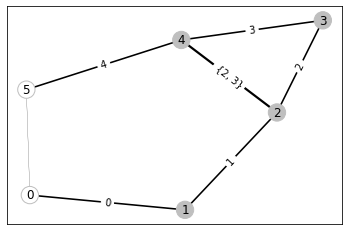

In [22]:
%matplotlib inline
m.draw()

While the noise and syndrome can be generated separately without PyMatching, if the optional `error_probability` attribute is given to every edge, then the edges can be flipped independently with the `error_probability` assigned to them using the `add_noise` method:

In [23]:
from pymatching import set_seed
set_seed(1) # Keep RNG deterministic

noise, syndrome = m.add_noise()
print(noise)
print(syndrome)

[0 1 0 0 0]
[0 1 1 0 0 0]


We can now decode as before using the `decode` method:

In [24]:
correction = m.decode(syndrome)
print((correction+noise)%2)

[0 0 0 0 0]
